In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import os 
os.chdir("D:\\Technocolabs Data Science Internship")
df = pd.read_csv('data.csv')
df.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [3]:
# Correlation Matrix
corr_matrix = df.corr()
corr_matrix.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [7]:
x = df.drop(["genre_top","track_id"], axis=1)

y = df["genre_top"]

#standardization
std_scaled = preprocessing.StandardScaler().fit_transform(x)

In [8]:
# Principle Component Analysis for Feature Selection
pca = PCA()
pca.fit(std_scaled)

PCA()

In [9]:
var = pca.explained_variance_ratio_
var

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

<BarContainer object of 8 artists>

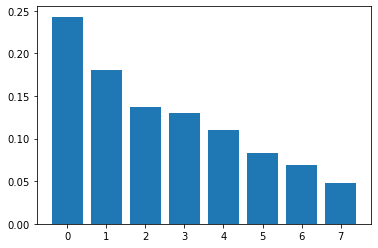

In [11]:
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),var)

In [13]:
cumulative_var = np.cumsum(var)
cumulative_var

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

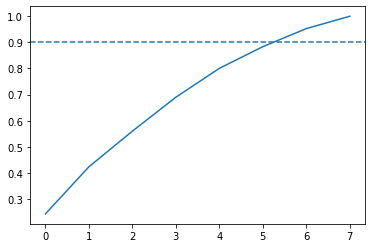

In [14]:
fig, ax = plt.subplots()
ax.plot(range(8), cumulative_var)
ax.axhline(y=0.9, linestyle='--')

In [15]:
n_components = 5
pca = PCA(n_components, random_state=1)
pca.fit(std_scaled)
pca_projection = pca.transform(std_scaled)
pca_projection

array([[ 1.59666656,  1.0500117 , -0.01778555,  0.73142514, -0.36832686],
       [ 1.58153526,  1.07661327,  1.04346038,  0.16929959, -1.81917099],
       [ 2.01545627,  1.4085176 ,  0.24506524, -1.53545814,  0.62769959],
       ...,
       [ 1.66908628,  1.84010121,  2.38294303, -2.12871589,  1.23664547],
       [ 1.17001951,  2.03158181,  0.08689922,  0.88396123, -1.45765649],
       [ 2.36368976,  1.15900708,  0.4473735 , -1.35198128, -0.03592518]])

In [16]:
pca_projection.shape

(4802, 5)

## Model Building

In [17]:
train_x, test_x, train_y, test_y = train_test_split(pca_projection, y_target,random_state=42)

treeclf = DecisionTreeClassifier(random_state=96)
treeclf.fit(train_x,train_y)

y_pred = treeclf.predict(test_x)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
cm = confusion_matrix(test_y, y_pred)
print(cm)
accuracy_score(test_y, y_pred)

[[142  83]
 [ 88 888]]


0.8576186511240633

In [20]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

     Hip-Hop       0.62      0.63      0.62       225
        Rock       0.91      0.91      0.91       976

    accuracy                           0.86      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.86      0.86      0.86      1201



## Balance Data

In [21]:
hop = df.loc[df["genre_top"] == "Hip-Hop"]
rock = df.loc[df["genre_top"] == "Rock"]

In [22]:
print(len(hop))
print(len(rock))

910
3892


In [23]:
balanced_dataset = pd.concat([rock.sample(n=910,random_state=10), hop.sample(n=910)], axis=0)
balanced_dataset.genre_top.value_counts()

Hip-Hop    910
Rock       910
Name: genre_top, dtype: int64

In [25]:
x_features_bal = balanced_dataset.drop(['genre_top', 'track_id'], axis=1) 
y_target_bal = balanced_dataset['genre_top']
std_scaled_bal = preprocessing.StandardScaler().fit_transform(x_features_bal)

pca_bal = PCA(n_components, random_state=1)
pca_bal.fit(std_scaled_bal)
pca_projection_bal = pca.transform(std_scaled_bal)

In [26]:
pca_projection_bal.shape

(1820, 5)

In [27]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(pca_projection_bal, y_target_bal,random_state=0)

# Train our decision tree
tree_bal = DecisionTreeClassifier(random_state=42)
tree_bal.fit(X_train_bal, y_train_bal)

#Predicting the Test set results
y_pred_bal = tree_bal.predict(X_test_bal)

In [28]:
print(X_train_bal.shape)
print(X_test_bal.shape)
print(y_train_bal.shape)
print(y_test_bal.shape)

(1365, 5)
(455, 5)
(1365,)
(455,)


In [35]:
cm_bal = confusion_matrix(y_test_bal, y_pred_bal)
print(cm_bal)
accuracy_score(y_test_bal, y_pred_bal)

[[168  61]
 [ 37 189]]


0.7846153846153846

In [37]:
classifier_bal = LogisticRegression(random_state = 42)
classifier_bal.fit(X_train_bal, y_train_bal)
y_pred_logreg_bal = classifier_bal.predict(X_test_bal)

In [38]:

cm_bal = confusion_matrix(y_test_bal, y_pred_logreg_bal)
print(cm_bal)
accuracy_score(y_test_bal, y_pred_logreg_bal)

[[180  49]
 [ 34 192]]


0.8175824175824176

## Using Cross Validation

In [30]:

from sklearn.model_selection import KFold, cross_val_score

In [31]:
kf = KFold(n_splits=30)

In [32]:
tree = DecisionTreeClassifier(random_state=42)
logreg = LogisticRegression(random_state=42)

In [33]:
tree_score = cross_val_score(tree, pca_projection, y_target, cv=kf)
log_reg_score = cross_val_score(logreg, pca_projection,y_target, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(log_reg_score))

Decision Tree: 0.8400465838509317 Logistic Regression: 0.8714855072463767


In [39]:
model = "model.pkl"  

with open(model, 'wb') as f:  
    pickle.dump(classifier_bal, f)